# High-Level Overview of the Notebook

The notebook covers the following sections:

---

## **1. Introduction**
   - Overview of the problem: Detecting spam emails using machine learning.
   - Importance of email spam filtering.
   - Project goals and approach.

---

## **2. Data Exploration and Preprocessing**
   - Loading the dataset (`spam.csv`).
   - Exploratory Data Analysis (EDA):
     - Distribution of spam vs. ham emails.
     - Word cloud visualization of spam and ham emails.
   - Text preprocessing:
     - Lowercasing
     - Removing punctuation, stopwords, and special characters
     - Tokenization

---

## **3. Feature Engineering**
   - Conversion of text data to numerical features:
     - **Bag-of-Words (BoW)** using Count Vectorizer.
     - **TF-IDF** (Term Frequency-Inverse Document Frequency).

---

## **4. Baseline Model: Multinomial Naive Bayes**
   - Splitting the dataset into training and testing sets.
   - Training the **Multinomial Naive Bayes** model.
   - Model evaluation:
     - Accuracy
     - Precision, Recall, F1-score
     - Confusion Matrix

---

## **5. Transfer Learning with Pre-Trained Models**
   - Introduction to transfer learning for text classification.
   - Fine-tuning **BERT** or **DistilBERT** on the spam dataset.
   - Training process and hyperparameter tuning.
   - Evaluation of the fine-tuned model:
     - Accuracy
     - Precision, Recall, F1-score
     - ROC-AUC score

---

## **6. Results Comparison**
   - Compare results between:
     - **Baseline Model (Multinomial Naive Bayes)**.
     - **Transfer Learning Model (BERT)**.
   - Visualization:
     - Confusion Matrix
     - Precision-Recall Curve
     - Training Loss and Accuracy Curves

---

## **7. Conclusion**
   - Key findings and performance summary.
   - Insights on model performance improvement using transfer learning.
   - Suggestions for further enhancements.

---

## **8. Future Work**
   - Deploy the model as a web application.
   - Explore other pre-trained models (e.g., RoBERTa, ALBERT).
   - Optimize model efficiency for real-time spam detection.


# Importing Libraries

In [24]:
# ! pip install wordcloud
! pip install transformers torch


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/0d/4a/e51420d46cfc90562e85af2fee912237c662ab31140ab179e49bd69401d6/torch-2.5.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/203.1 MB 3.4 MB/s eta 0:01:00
   ---------------------------------------- 0.5/203.1 MB 6.3 MB/s eta 0:00:33
   ---------------------------------------- 1.3/203.1 MB 10.4 MB/s eta 0:00:20
   ---------------------------------------- 1.9/203.1 MB 10

In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix


# Read in Data

In [3]:
data=pd.read_csv("spam.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# EDA

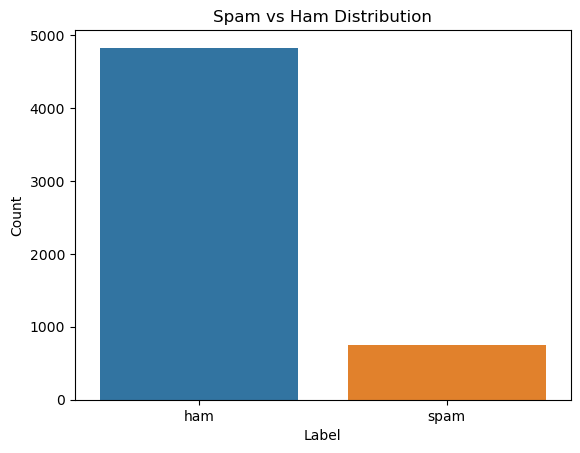

In [6]:
# Visualize distribution
sns.countplot(x='Category', data=data)
plt.title("Spam vs Ham Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

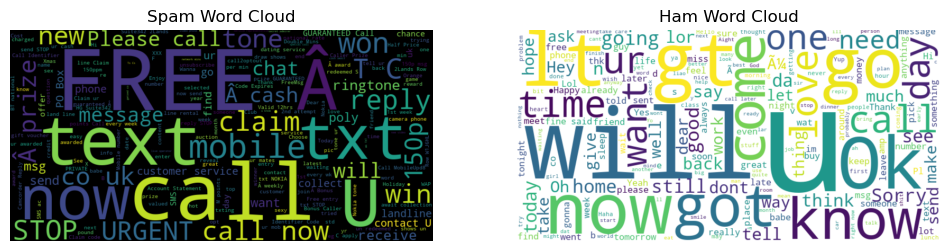

In [10]:
# Word cloud for Spam
spam_words = ' '.join(data[data['Category'] == 'spam']['Message'])
spam_wc = WordCloud(width=800, height=400, background_color='black').generate(spam_words)

# Word cloud for Ham
ham_words = ' '.join(data[data['Category'] == 'ham']['Message'])
ham_wc = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

# Display Word Clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Spam Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Ham Word Cloud")

plt.show()

# Data Preprocessing

## Text Preprocessing

### Lowercasing, Removing Punctuation, and Stopwords:

In [15]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join(char for char in text if char not in string.punctuation)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply preprocessing
data['clean_message'] = data['Message'].apply(preprocess)
data.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sathw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Category,Message,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


# Feature Engineering

### Converting Text to Numerical Features Using CountVectorizer and TF-IDF Vectorizer.

In [18]:
# Count Vectorization
cv = CountVectorizer()
X_cv = cv.fit_transform(data['clean_message'])

# TF-IDF Vectorization
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(data['clean_message'])

# Target Variable Encoding
y = data['Category'].map({'ham': 0, 'spam': 1})

print("Count Vectorizer Shape:", X_cv.shape)
print("TF-IDF Vectorizer Shape:", X_tfidf.shape)


Count Vectorizer Shape: (5572, 9455)
TF-IDF Vectorizer Shape: (5572, 9455)


# Baseline Model: Multinomial Naive Bayes

#### Split Data into Training and Testing Sets

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


#### Train Multinomial Naive Bayes Model

In [22]:
# Train Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred = nb_model.predict(X_test)

# Evaluate Model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
[[966   0]
 [ 35 114]]


##### The Naive Bayes model works well overall but struggles with recall for spam emails. Balancing the dataset, adjusting thresholds, or experimenting with more sophisticated models could help improve performance, particularly for the minority class.

# Transformers Appoach

In [52]:
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
import tensorflow as tf



### Importing the pre trained models tokenizer

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


In [36]:
X =list(data['clean_message'])
y = data['Category'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# text = ["This is a spam email", "Please contact us for your prize"]
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)


#### Converting Encodings to Dataset objects

In [45]:

# Convert train encodings and labels into a Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),  # Tokenized inputs (input_ids, attention_mask, etc.)
    y_train                 # Corresponding labels
))

# Convert test encodings and labels into a Dataset object
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),   # Tokenized inputs for test set
    y_test                  # Corresponding labels
))


In [46]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(112,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(112,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [54]:
from transformers import TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',              # Output directory
    num_train_epochs=2,                  # Total number of training epochs
    per_device_train_batch_size=8,       # Batch size for training
    per_device_eval_batch_size=16,       # Batch size for evaluation
    warmup_steps=500,                    # Number of warmup steps
    weight_decay=0.01,                   # Weight decay for regularization
    logging_dir='./logs',                # Directory for logs
    logging_steps=10,                    # Log training metrics every 10 steps
    evaluation_strategy="steps",         # Evaluate after a fixed number of steps
    eval_steps=100                       # Evaluate every 100 steps
)


In [55]:
# Load DistilBERT model for sequence classification
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define the TFTrainer
trainer = TFTrainer(
    model=model,                          # Pre-trained model
    args=training_args,                   # Training arguments
    train_dataset=train_dataset,          # Tokenized training dataset
    eval_dataset=test_dataset             # Tokenized evaluation dataset
)

# Train the model
trainer.train()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [56]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.04136091981615339}

In [57]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[ 3.022022 , -2.979955 ],
       [ 3.0843065, -2.9978635],
       [ 3.166143 , -3.081219 ],
       ...,
       [ 3.1668396, -3.0887787],
       [ 3.1351588, -3.0236127],
       [ 2.9722831, -2.8644755]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0], dtype=int64), metrics={'eval_loss': 0.041361754281180246})

In [58]:
output = trainer.predict(test_dataset)[1]

In [59]:
confusion_matrix(y_test, output)

array([[966,   0],
       [  0, 149]], dtype=int64)

In [ ]:
# trainer.save_model("distilbert_spam_model")